# Linear Discriminant Analysis (LDA)

Author: https://github.com/deburky

This notebook is a simple implementation of Linear Discriminant Analysis (LDA) from scratch.



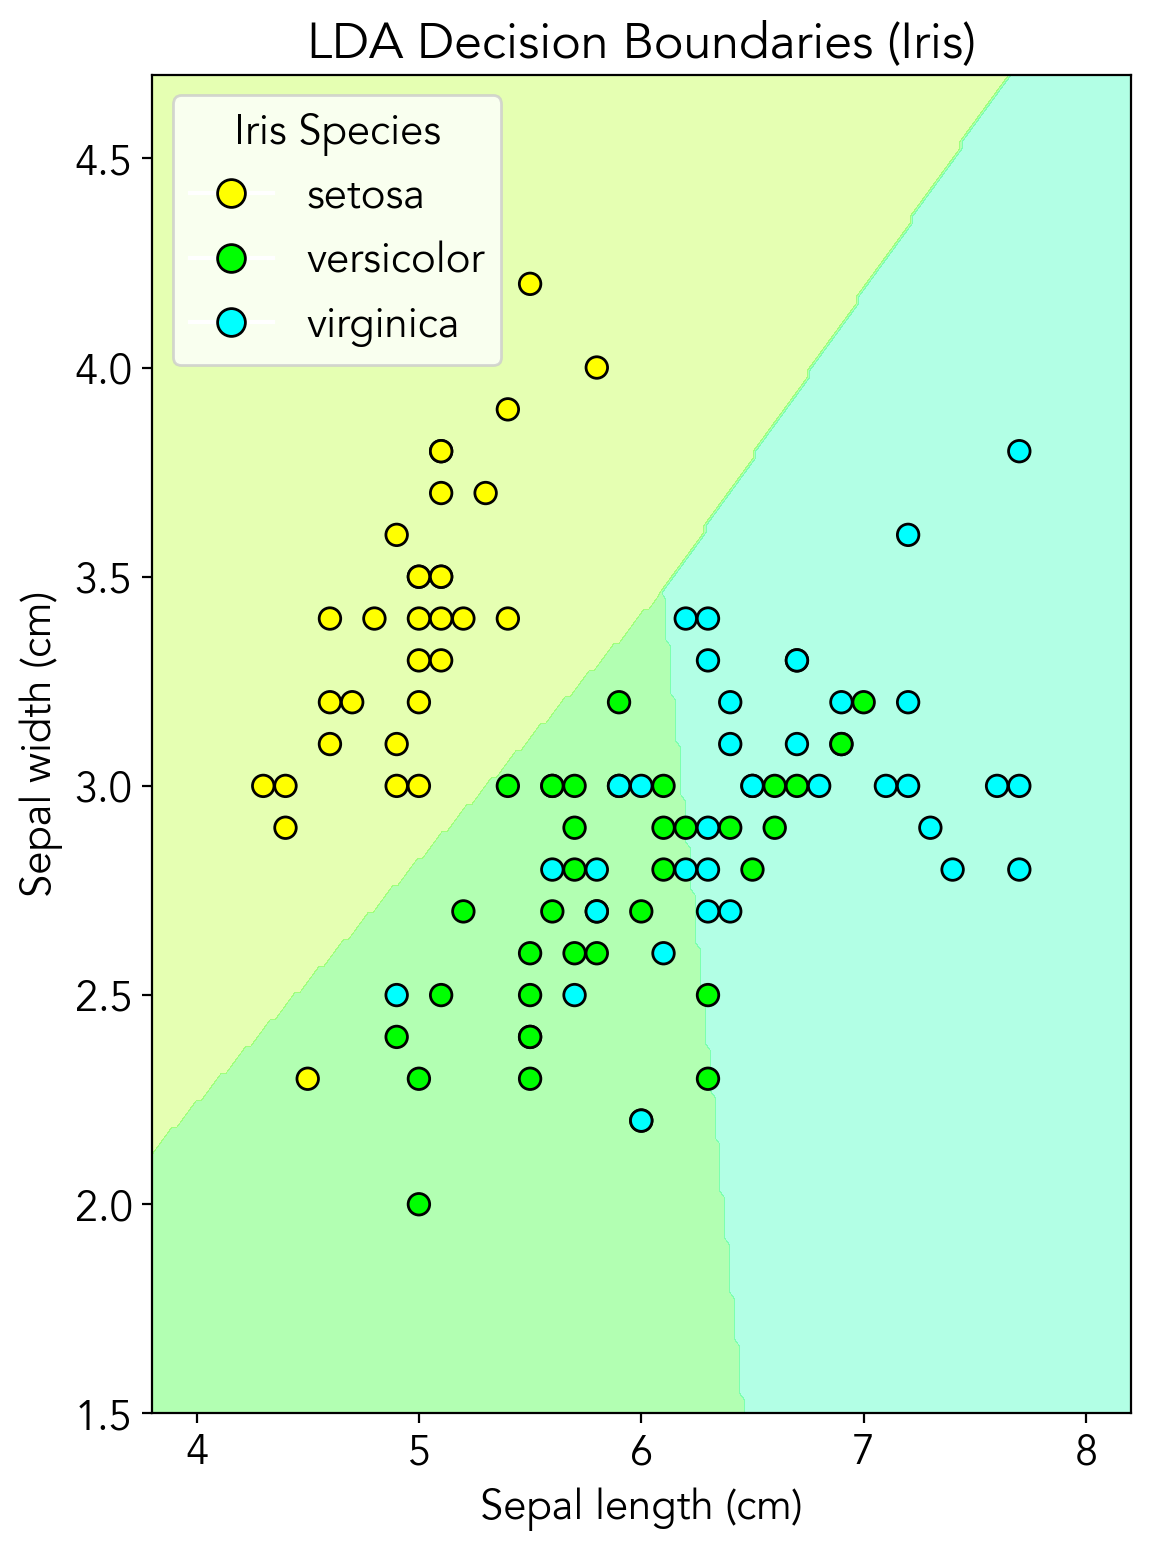

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from cmap import Colormap
from sklearn import datasets
from sklearn.model_selection import train_test_split

%config InlineBackend.figure_format = 'retina'

# Color maps

cmap1 = "chrisluts:ygc_3c"
cmap2 = "colorcet:cet_l19"
cm1 = Colormap(cmap1).to_mpl()
cm2 = Colormap(cmap2).to_mpl()

plt.rcParams["font.family"] = "Avenir"
plt.rcParams["font.size"] = 15

# Load Iris data for chosen features
iris = datasets.load_iris()

df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris["target"] = iris.target

class_names = iris.target_names
features = ["sepal length (cm)", "sepal width (cm)"]

X = df_iris[features].values
y = df_iris["target"].values

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)


class LDA:
    """Linear Discriminant Analysis (LDA) classifier."""

    def __init__(self):
        self.means = {}
        self.covariance = None
        self.priors = {}

    def fit(self, X, y):
        """Fit the LDA model to the training data."""
        self.classes = np.unique(y)
        n_features = X.shape[1]
        self.covariance = np.zeros((n_features, n_features))
        for cls in self.classes:
            X_cls = X[y == cls]
            self.means[cls] = np.mean(X_cls, axis=0)
            self.covariance += np.cov(X_cls, rowvar=False) * (len(X_cls) - 1)
            self.priors[cls] = len(X_cls) / len(y)
        self.covariance /= len(y) - len(self.classes)

    def discriminant_scores(self, X):
        """Compute the discriminant scores for each class."""
        scores = []
        inv_cov = np.linalg.inv(self.covariance)
        for cls in self.classes:
            mean = self.means[cls]
            prior = self.priors[cls]
            score = X @ inv_cov @ mean - 0.5 * mean.T @ inv_cov @ mean + np.log(prior)
            scores.append(score)
        return np.array(scores).T

    def predict(self, X):
        """Predict the class labels for the input data."""
        discriminants = []
        inv_cov = np.linalg.inv(self.covariance)
        for cls in self.classes:
            mean = self.means[cls]
            prior = self.priors[cls]
            discriminant = (
                X @ inv_cov @ mean - 0.5 * mean.T @ inv_cov @ mean + np.log(prior)
            )
            discriminants.append(discriminant)
        return np.argmax(discriminants, axis=0)

    def predict_proba(self, X):
        """Predict class probabilities for each class."""
        scores = self.discriminant_scores(X)
        exp_scores = np.exp(scores)
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)


def plot_decision_boundaries(X, y, model, class_names, feat_names, model_name, cmap):
    """Plot decision boundaries for a 2D dataset."""
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    Z = model.predict(grid).reshape(xx.shape)

    plt.figure(figsize=(6, 8))
    plt.contourf(
        xx,
        yy,
        Z,
        alpha=0.3,
        levels=np.arange(-0.5, len(class_names) + 0.5, 1),
        cmap=cmap,
    )
    plt.scatter(
        X[:, 0],
        X[:, 1],
        c=y,
        edgecolor="k",
        s=60,
        cmap=cmap,
        label=[class_names[i] for i in y],
    )
    # One legend entry per class
    handles = []
    handles.extend(
        plt.Line2D(
            [0],
            [0],
            marker="o",
            color="w",
            label=name,
            markerfacecolor=cmap(i / (len(class_names) - 1)),
            markeredgecolor="k",
            markersize=10,
        )
        for i, name in enumerate(class_names)
    )
    plt.legend(handles=handles, title="Iris Species", loc="upper left")
    plt.xlabel(feat_names[0].capitalize())
    plt.ylabel(feat_names[1].capitalize())
    plt.title(f"{model_name} Decision Boundaries (Iris)")
    plt.grid(False)
    plt.tight_layout()
    plt.show()


lda = LDA()
lda.fit(X_train, y_train)
y_pred = lda.predict(X_test)

plot_decision_boundaries(
    X_train,
    y_train,
    lda,
    class_names=class_names,
    feat_names=[features[0], features[1]],
    **{"model_name": "LDA", "cmap": cm1},
)


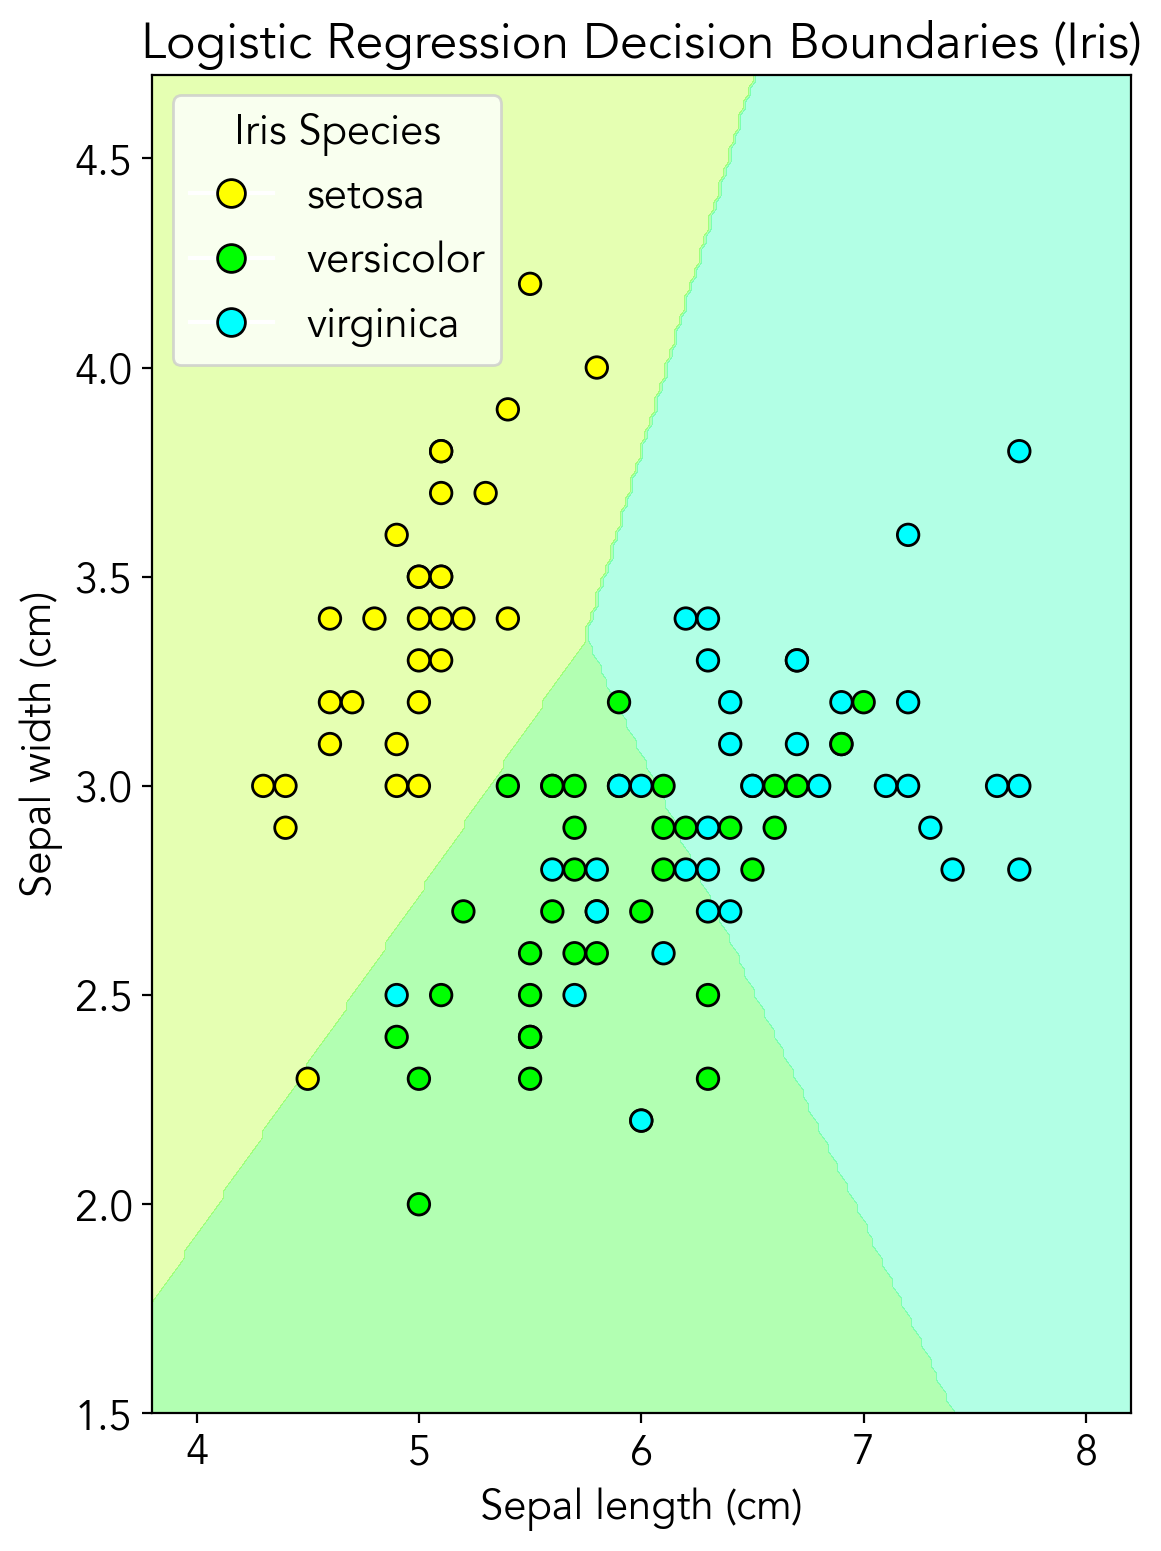

In [2]:
from sklearn.linear_model import LogisticRegression

# Train a Multinomial Logistic Regression model
log_reg = LogisticRegression(solver="newton-cg", random_state=42)
log_reg.fit(X_train, y_train)

# Predict labels for the test set
y_pred_log_reg = log_reg.predict(X_test)

plot_decision_boundaries(
    X_train,
    y_train,
    log_reg,
    class_names=class_names,
    feat_names=[features[0], features[1]],
    **{"model_name": "Logistic Regression", "cmap": cm1},
)

### Softmax function

In [3]:
import pandas as pd

pd.set_option("display.precision", 2)

pd.DataFrame(lda.predict_proba(X_test)).head(5)

,0,1,2
0,1.56e-04,5.69e-01,4.31e-01
1,9.99e-01,9.16e-04,4.25e-04
2,8.52e-12,3.56e-02,9.64e-01
3,1.19e-03,6.13e-01,3.86e-01
4,3.79e-07,2.10e-01,7.90e-01


In [4]:
import pandas as pd
from sklearn.metrics import roc_auc_score


# Calculate Gini coefficient for each class
def calculate_gini(preds, y_true):
    gini_scores = {}
    for col in preds.columns:
        auc = roc_auc_score(
            (y_true == col).astype(int), preds[col]
        )  # AUC for binary classification (class vs rest)
        gini = 2 * auc - 1
        gini_scores[f"Class {col}"] = gini
    return gini_scores


# Gini for LDA
preds_test_lda = pd.DataFrame(lda.predict_proba(X_test), columns=lda.classes)
gini_lda = calculate_gini(preds_test_lda, y_test)

# Gini for Logistic Regression
preds_test_log_reg = pd.DataFrame(
    log_reg.predict_proba(X_train), columns=log_reg.classes_
)
gini_log_reg = calculate_gini(preds_test_log_reg, y_train)

# Display Gini scores
print("Gini Coefficients for LDA:")
for cls, gini in gini_lda.items():
    print(f"{cls}: {gini:.4f}")

print("\nGini Coefficients for Logistic Regression:")
for cls, gini in gini_log_reg.items():
    print(f"{cls}: {gini:.4f}")

Gini Coefficients for LDA:
Class 0: 1.0000
Class 1: 0.7812
Class 2: 0.8101

Gini Coefficients for Logistic Regression:
Class 0: 1.0000
Class 1: 0.7576
Class 2: 0.7878


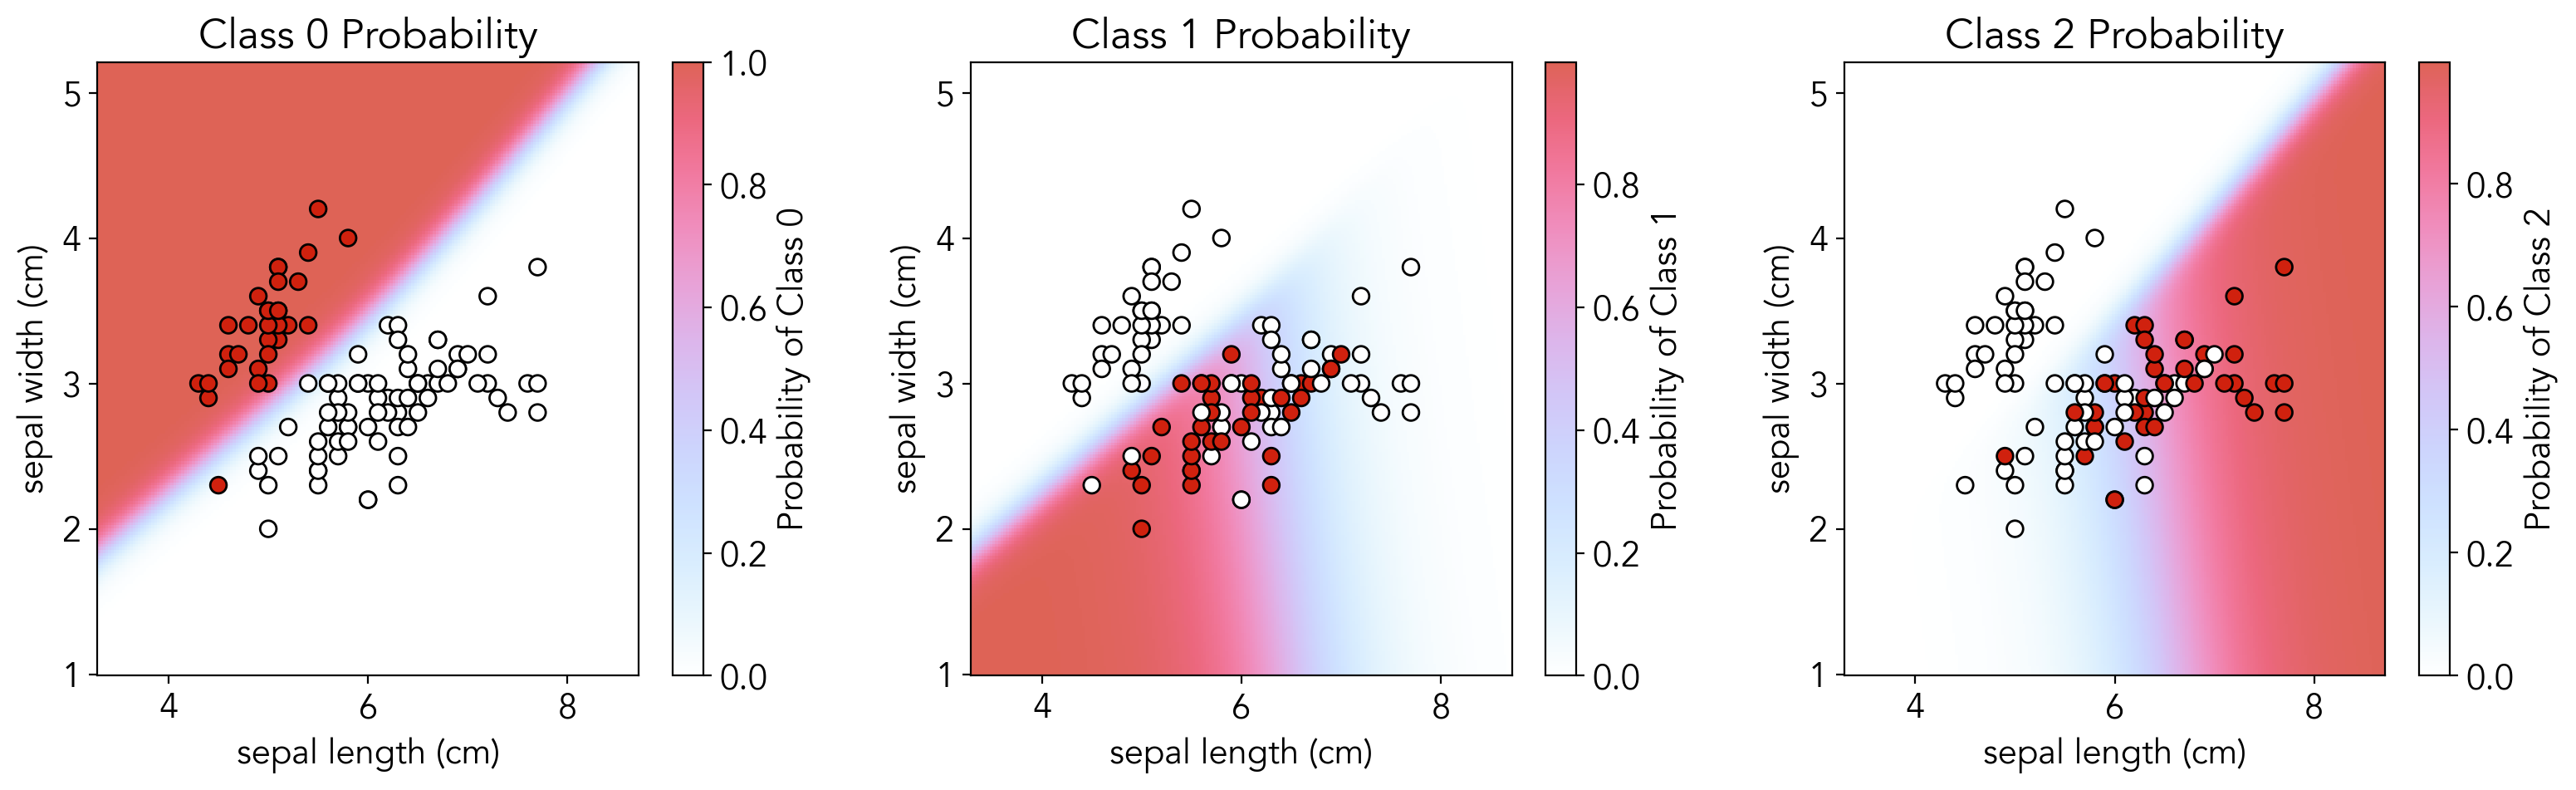

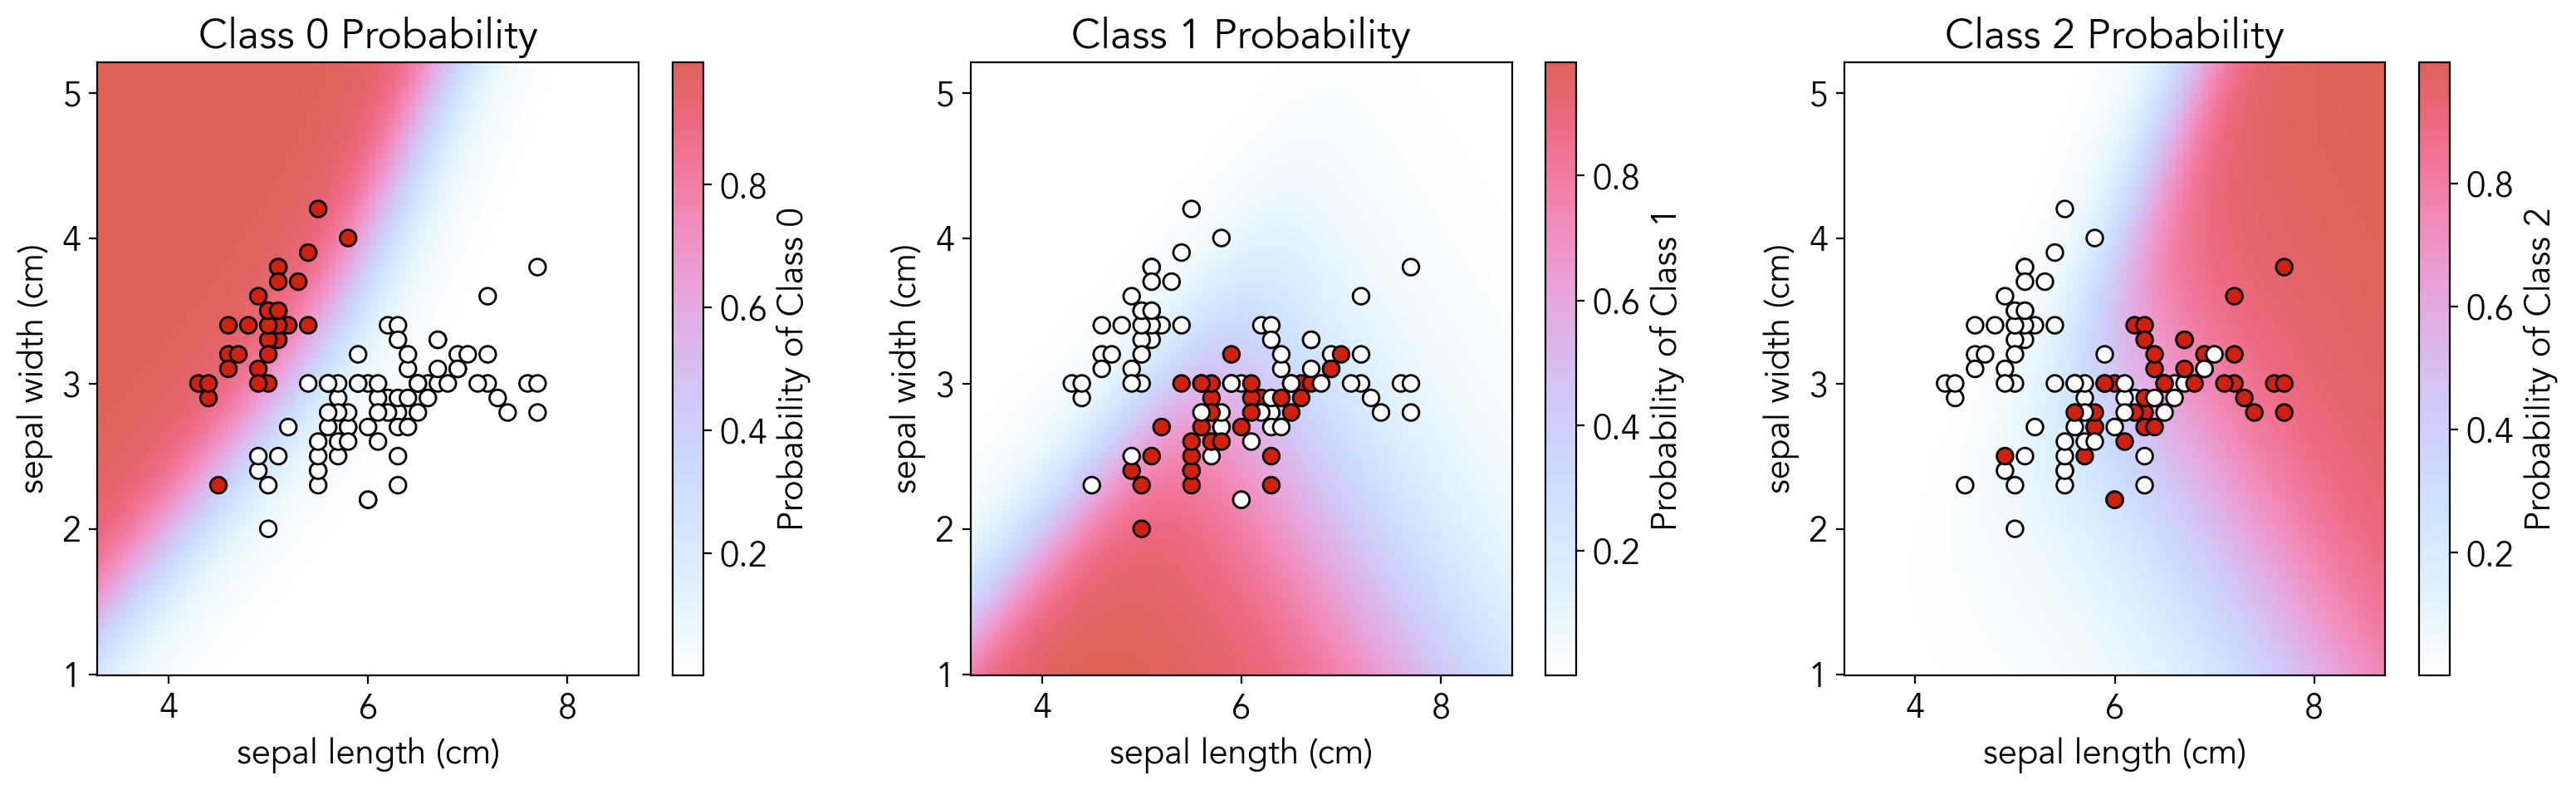

In [5]:
# Visualization of Multinomial Probabilities
def plot_probabilities(X, y, model, features):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200), np.linspace(y_min, y_max, 200))
    grid = np.c_[xx.ravel(), yy.ravel()]
    probabilities = model.predict_proba(grid)  # Shape: (n_points, n_classes)

    # Reshape probabilities for plotting
    prob_class_0 = probabilities[:, 0].reshape(xx.shape)
    prob_class_1 = probabilities[:, 1].reshape(xx.shape)
    prob_class_2 = probabilities[:, 2].reshape(xx.shape)

    plt.figure(figsize=(16, 5))

    # Plot for Class 0
    plt.subplot(1, 3, 1)
    plt.pcolormesh(xx, yy, prob_class_0, shading="auto", cmap=cm2, alpha=0.7)
    plt.colorbar(label="Probability of Class 0")
    binary0 = (y == 0).astype(int)
    _add_binary_labels(X, binary0, cm2, "Class 0 Probability")
    # Plot for Class 1
    plt.subplot(1, 3, 2)
    plt.pcolormesh(xx, yy, prob_class_1, shading="auto", cmap=cm2, alpha=0.7)
    plt.colorbar(label="Probability of Class 1")
    binary1 = (y == 1).astype(int)
    _add_binary_labels(X, binary1, cm2, "Class 1 Probability")
    # Plot for Class 2
    plt.subplot(1, 3, 3)
    plt.pcolormesh(xx, yy, prob_class_2, shading="auto", cmap=cm2, alpha=0.7)
    plt.colorbar(label="Probability of Class 2")
    binary2 = (y == 2).astype(int)
    _add_binary_labels(X, binary2, cm2, "Class 2 Probability")
    plt.tight_layout()
    plt.show()


def _add_binary_labels(X, c, cmap, title):
    plt.scatter(X[:, 0], X[:, 1], c=c, edgecolor="k", s=50, cmap=cmap)
    plt.title(title)
    plt.xlabel(features[0])
    plt.ylabel(features[1])


# Visualize the probabilities
plot_probabilities(X_train, y_train, lda, features=[features[0], features[1]])
plot_probabilities(X_train, y_train, log_reg, features=[features[0], features[1]])

In [6]:
from rich import print as rprint
from sklearn.metrics import classification_report

# Classification report for LDA
lda_y_pred = lda.predict(X_test)
lda_report = classification_report(y_test, lda_y_pred, target_names=iris.target_names)
print("Linear Discriminant Analysis (LDA):")
rprint(lda_report)

# Classification report for Logistic Regression
log_reg_y_pred = log_reg.predict(X_test)
log_reg_report = classification_report(
    y_test, log_reg_y_pred, target_names=iris.target_names
)
print("\nMultinomial Logistic Regression:")
rprint(log_reg_report)

Linear Discriminant Analysis (LDA):


precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.80      0.62      0.70        13
   virginica       0.69      0.85      0.76        13

    accuracy                           0.84        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.85      0.84      0.84        45


Multinomial Logistic Regression:


precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        19
  versicolor       0.78      0.54      0.64        13
   virginica       0.65      0.85      0.73        13

    accuracy                           0.82        45
   macro avg       0.81      0.79      0.79        45
weighted avg       0.83      0.82      0.82        45

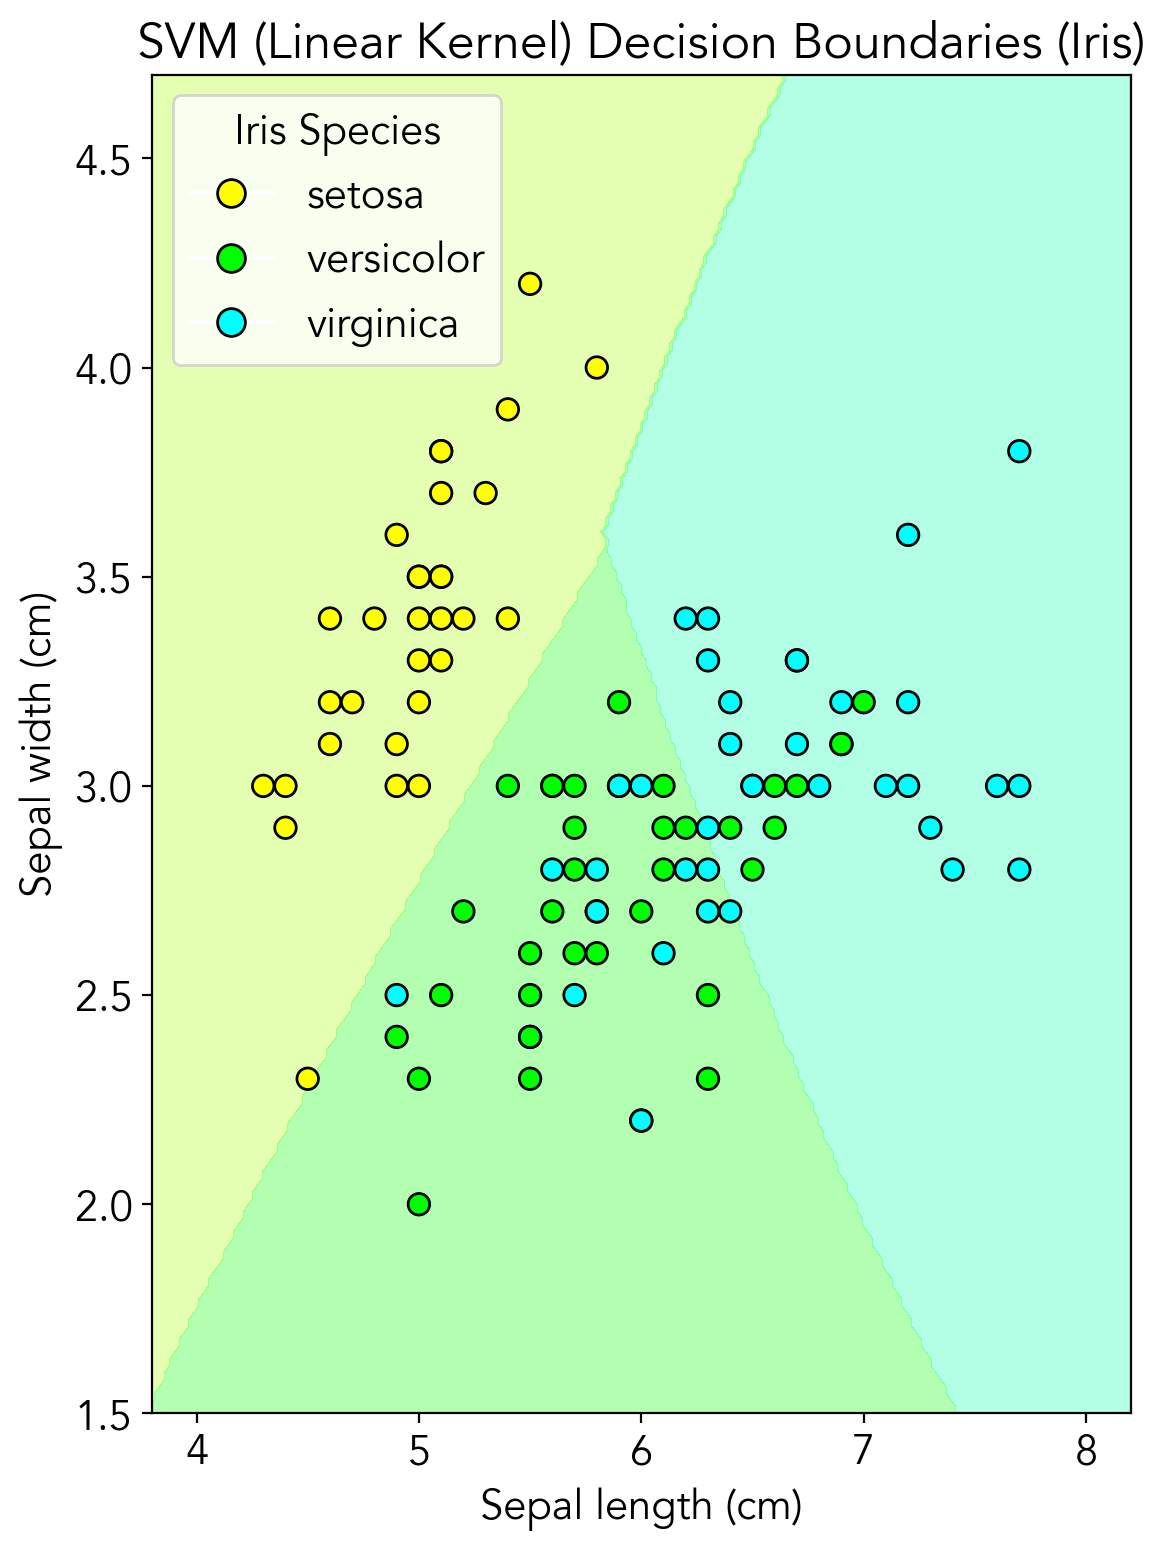

In [7]:
from sklearn.svm import SVC

# Train an SVM model with a linear kernel
svm_linear = SVC(kernel="rbf", C=1, random_state=42)
svm_linear.fit(X_train, y_train)

# Predict labels for the test set
y_pred_svm = svm_linear.predict(X_test)


# Visualize decision boundaries for SVM with a linear kernel
plot_decision_boundaries(
    X_train,
    y_train,
    svm_linear,
    class_names=class_names,
    feat_names=[features[0], features[1]],
    **{"model_name": "SVM (Linear Kernel)", "cmap": cm1},
)